In [1]:
import pandas as pd
import numpy as np

In [2]:
df_train_labels = pd.read_csv('./Dataset/train_labels.csv')

In [3]:
df_train_labels.value_counts('category')

category
0    132
2    126
1    109
3    100
Name: count, dtype: int64

Pretty balanced. Likely no need for explicit up/downsampling on this trainset.

In [4]:
import torch
from torch.utils.data import DataLoader, Dataset
from torch import nn, optim
from torchvision.models import alexnet, AlexNet_Weights
from torchvision import datasets

In [5]:
print(torch.cuda.is_available())
print(torch.cuda.get_device_name(0))

True
NVIDIA GeForce RTX 4070 Ti


In [6]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

Have a look at the images first and process:

In [7]:
from pathlib import Path
import matplotlib.pyplot as plt
plt.rcParams["savefig.bbox"] = 'tight'
from torchvision.transforms import v2
from torchvision.io import read_image
torch.manual_seed(1) # seed

In [8]:
from helpers import plot

In [9]:
img = read_image(str(Path('./Dataset/train') / 'ytxwzobtsl.jpeg'))

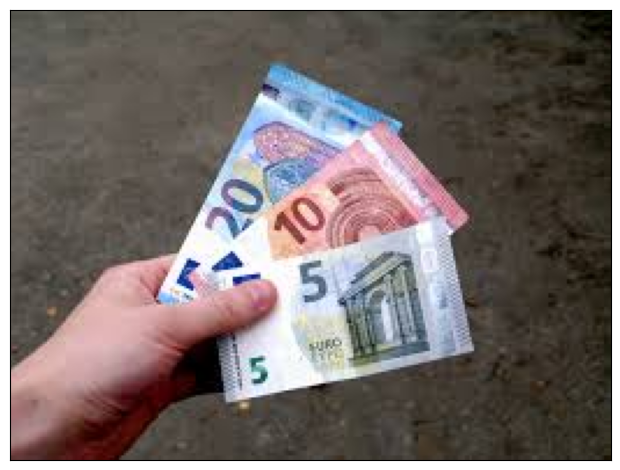

In [10]:
plot([img])

Initialise an AlexNet (with weights) and see if we can train anything.

In [11]:
weights = AlexNet_Weights.DEFAULT
model = alexnet(weights = None) # weights = weights

In [12]:
standard_preprocess = weights.transforms()

In [13]:
import random
def random_combination(iterable, r):
    "Random selection from itertools.combinations(iterable, r)"
    pool = tuple(iterable)
    n = len(pool)
    indices = sorted(random.sample(range(n), r))
    return tuple(pool[i] for i in indices)

In [14]:
from os import listdir
from os.path import isfile, join

onlyfiles = [f for f in listdir('./Dataset/train') if isfile(join('./Dataset/train', f))]

c:\Users\zoga\anaconda3\envs\kaggle_comp\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(
c:\Users\zoga\anaconda3\envs\kaggle_comp\Lib\site-packages\torchvision\transforms\functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.1

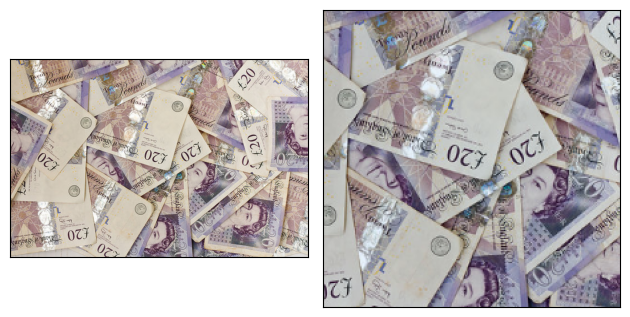

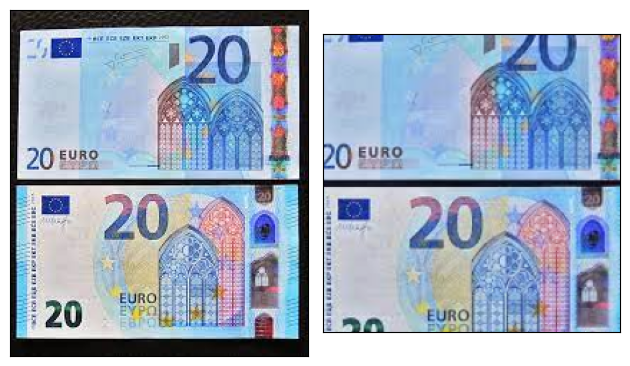

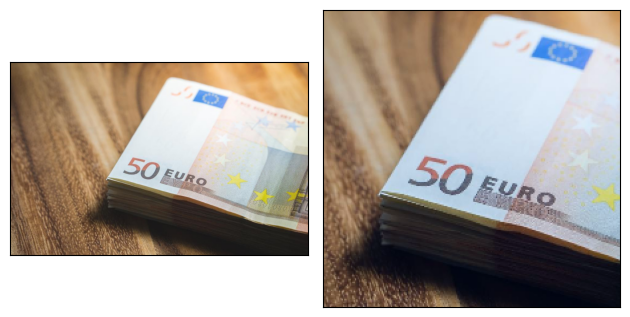

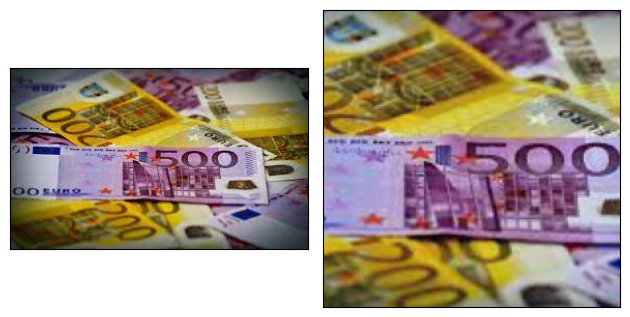

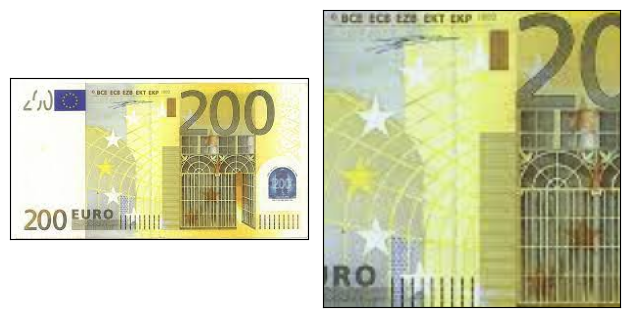

In [15]:
random_selection = 5

for img_path in random_combination(onlyfiles, random_selection):

    img = read_image(str(Path('./Dataset/train') / img_path))

    plot([img, standard_preprocess(img)])

We need to add a layer with 4 neurons.

In [16]:
model_classifier = nn.Sequential(model, nn.Linear(1000, 4))

In [17]:
model_classifier.to(device)

Sequential(
  (0): AlexNet(
    (features): Sequential(
      (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
      (1): ReLU(inplace=True)
      (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
      (4): ReLU(inplace=True)
      (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
      (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (7): ReLU(inplace=True)
      (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (9): ReLU(inplace=True)
      (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (11): ReLU(inplace=True)
      (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    )
    (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
    (classifier): Sequential(
      (0): Dropout(p=0.5, inplace=False)
      (1):

Now let's get all the images in one place.

In [18]:
import os
import shutil

In [19]:
df_train_labels['dset'] = np.random.choice(['train', 'val'], size = len(df_train_labels), p = [0.8, 0.2])

In [20]:
df_train_labels[df_train_labels.dset == 'val']['category'].value_counts()

category
0    34
2    27
1    24
3    22
Name: count, dtype: int64

In [21]:
for dset_type in ['train', 'val']:

    for cat in df_train_labels['category'].unique(): # Get all unique categories

        Path("./Dataset_Categorised/train/" + str(cat)).mkdir(parents=True, exist_ok=True)
        Path("./Dataset_Categorised/val/" + str(cat)).mkdir(parents=True, exist_ok=True)


        for file_path in df_train_labels[(df_train_labels['category'] == cat) & (df_train_labels['dset'] == dset_type)].iterrows(): # Loop through and move file path for file in category
            shutil.copyfile('./Dataset/train/' + file_path[1].filename, './Dataset_Categorised/' + str(dset_type) + '/' + str(cat) + '/' + file_path[1].filename)

In [22]:
data_transforms = {
                    'train': v2.Compose([
                                v2.RandomApply([v2.RandAugment()], p = .5),
                            v2.RandomResizedCrop(size=(224, 224), antialias=True),
                            v2.RandomHorizontalFlip(p=0.5),
                            v2.ToTensor(),
                            v2.ToDtype(torch.float32, scale=True),
                            v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
                    # 'train': v2.Compose([v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET), v2.ToTensor(), v2.ToDtype(torch.float32, scale=True), v2.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])]),
                   'val': standard_preprocess}

c:\Users\zoga\anaconda3\envs\kaggle_comp\Lib\site-packages\torchvision\transforms\v2\_deprecated.py:43: UserWarning: The transform `ToTensor()` is deprecated and will be removed in a future release. Instead, please use `v2.Compose([v2.ToImage(), v2.ToDtype(torch.float32, scale=True)])`.
  warnings.warn(


In [23]:
data_dir = './Dataset_Categorised/'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4,
                                             shuffle=True, num_workers=4)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

In [24]:
type(v2.AutoAugment(v2.AutoAugmentPolicy.IMAGENET)(img))

torch.Tensor

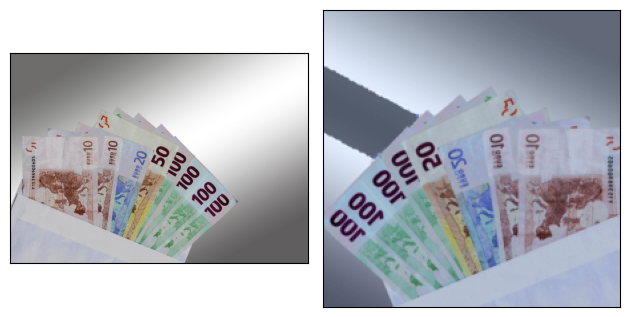

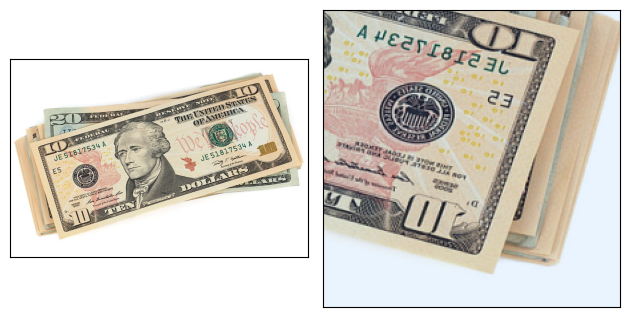

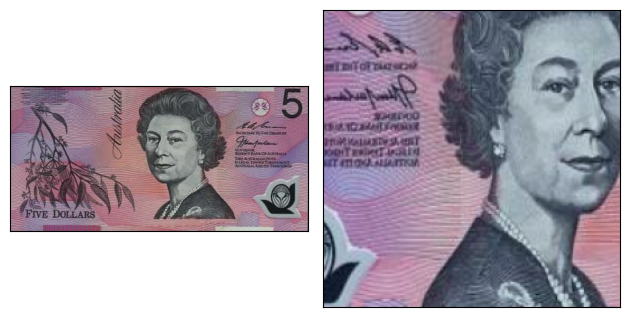

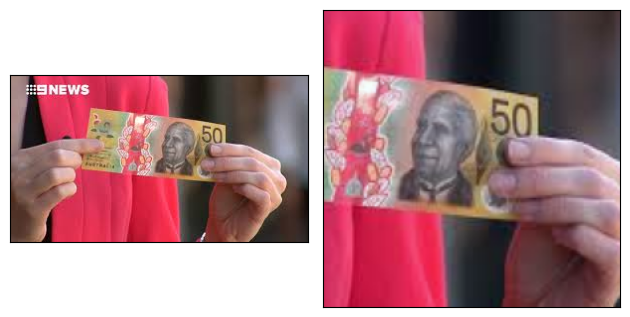

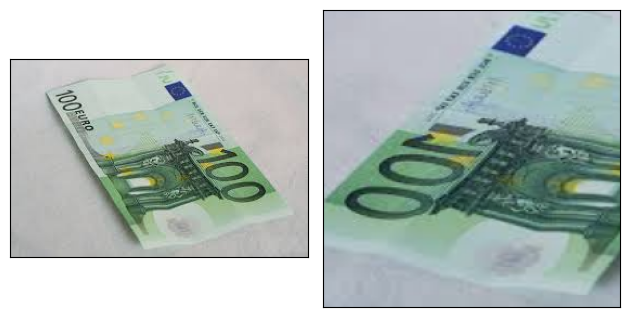

In [25]:
random_selection = 5

for img_path in random_combination(onlyfiles, random_selection):

    img = read_image(str(Path('./Dataset/train') / img_path))

    plot([img, data_transforms['train'](img)])

    plt.show()

In [26]:
import time

In [27]:
from tempfile import TemporaryDirectory

In [28]:
dataloaders

{'train': <torch.utils.data.dataloader.DataLoader at 0x1f561caf250>,
 'val': <torch.utils.data.dataloader.DataLoader at 0x1f561e6ec50>}

In [29]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=5):
    since = time.time()

    # Create a temporary directory to save training checkpoints
    with TemporaryDirectory() as tempdir:
        best_model_params_path = os.path.join(tempdir, 'best_model_params.pt')

        torch.save(model.state_dict(), best_model_params_path)
        best_acc = 0.0

        for epoch in range(num_epochs):
            print(f'Epoch {epoch}/{num_epochs - 1}')
            print('-' * 10)

            # Each epoch has a training and validation phase
            for phase in ['train', 'val']:
                if phase == 'train':
                    model.train()  # Set model to training mode
                else:
                    model.eval()   # Set model to evaluate mode

                running_loss = 0.0
                running_corrects = 0

                # Iterate over data.
                for inputs, labels in dataloaders[phase]:
                    inputs = inputs.to(device)
                    labels = labels.to(device)

                    # zero the parameter gradients
                    optimizer.zero_grad()

                    # forward
                    # track history if only in train
                    with torch.set_grad_enabled(phase == 'train'):
                        outputs = model(inputs)
                        _, preds = torch.max(outputs, 1)
                        loss = criterion(outputs, labels)

                        # backward + optimize only if in training phase
                        if phase == 'train':
                            loss.backward()
                            optimizer.step()

                    # statistics
                    running_loss += loss.item() * inputs.size(0)
                    running_corrects += torch.sum(preds == labels.data)
                if phase == 'train':
                    scheduler.step()

                epoch_loss = running_loss / dataset_sizes[phase]
                epoch_acc = running_corrects.double() / dataset_sizes[phase]

                print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

                # deep copy the model
                if phase == 'val' and epoch_acc > best_acc:
                    best_acc = epoch_acc
                    torch.save(model.state_dict(), best_model_params_path)

            print()

        time_elapsed = time.time() - since
        print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
        print(f'Best val Acc: {best_acc:4f}')

        # load best model weights
        model.load_state_dict(torch.load(best_model_params_path))
    return model

In [30]:
optimizer_ft = optim.Adam(model_classifier.parameters(), lr=1e-4)
exp_lr_scheduler = optim.lr_scheduler.StepLR(optimizer_ft, step_size=10, gamma=0.8)

In [31]:
criterion = nn.CrossEntropyLoss()

In [32]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [33]:
model_ft = train_model(model_classifier, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=60)

Epoch 0/59
----------
train Loss: 1.3890 Acc: 0.2548
val Loss: 1.3664 Acc: 0.3445

Epoch 1/59
----------
train Loss: 1.3920 Acc: 0.2827
val Loss: 1.3813 Acc: 0.3893

Epoch 2/59
----------
train Loss: 1.3740 Acc: 0.3041
val Loss: 1.3391 Acc: 0.2975

Epoch 3/59
----------
train Loss: 1.3718 Acc: 0.2869
val Loss: 1.3451 Acc: 0.3848

Epoch 4/59
----------
train Loss: 1.3315 Acc: 0.3383
val Loss: 1.2591 Acc: 0.4027

Epoch 5/59
----------
train Loss: 1.2835 Acc: 0.3533
val Loss: 1.1991 Acc: 0.4206

Epoch 6/59
----------
train Loss: 1.2770 Acc: 0.4090
val Loss: 1.2304 Acc: 0.4295

Epoch 7/59
----------
train Loss: 1.2673 Acc: 0.3662
val Loss: 1.1620 Acc: 0.3826

Epoch 8/59
----------
train Loss: 1.2597 Acc: 0.4004
val Loss: 1.1897 Acc: 0.4497

Epoch 9/59
----------
train Loss: 1.2084 Acc: 0.4004
val Loss: 1.1350 Acc: 0.4899

Epoch 10/59
----------
train Loss: 1.1921 Acc: 0.4154
val Loss: 1.1154 Acc: 0.4318

Epoch 11/59
----------
train Loss: 1.1708 Acc: 0.4090
val Loss: 1.1017 Acc: 0.4922

Ep

In [34]:
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are update

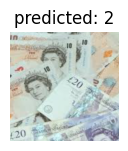

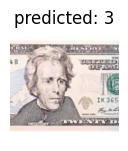

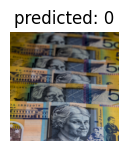

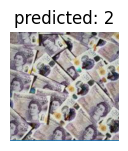

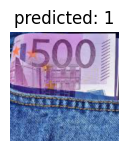

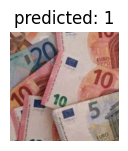

In [35]:
visualize_model(model_ft)

plt.ioff()
plt.show()

In [36]:
from PIL import Image

In [37]:
def visualize_model_predictions(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = standard_preprocess(img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        ax = plt.subplot(2,2,1)
        ax.axis('off')
        ax.set_title(f'Predicted: {class_names[preds[0]]}')
        imshow(img.cpu().data[0])

        model.train(mode=was_training)

In [38]:
def predict(model,img_path):
    was_training = model.training
    model.eval()

    img = Image.open(img_path)
    img = data_transforms['val'](img)
    img = img.unsqueeze(0)
    img = img.to(device)

    with torch.no_grad():
        outputs = model(img)
        _, preds = torch.max(outputs, 1)

        return preds

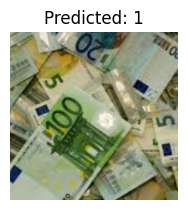

In [39]:
visualize_model_predictions(
    model_ft,
    img_path='./Dataset/test/aapvlatnvr.jpeg'
)

plt.ioff()
plt.show()

In [40]:
predict(model_ft, './Dataset/test/aapvlatnvr.jpeg').cpu().item()

1

In [41]:
all_test_files_jpeg = listdir('./Dataset/test/')
all_test_files = ['./Dataset/test/' + i for i in all_test_files_jpeg]

In [42]:
all_test_pred = []
for file_str in all_test_files:
    all_test_pred.append(predict(model_ft, file_str).cpu().item())

In [43]:
pd.DataFrame({'filename': all_test_files_jpeg, 'category':all_test_pred }).to_csv('submission_1_basic_alexnet_augmented.csv', index=False)

In [44]:
len(all_test_pred)

481